In [1]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
from creditlearning import CreditLearner
import matplotlib

### Demonstration of Multiple Superimposed Copies of Renewal Process

In [2]:
class MultipleWalkers:
    
    def __init__(self,transitionMat,timeMeans,timeVars):
        self.transitionMat = transitionMat
        self.vocabSize = len(transitionMat)
        self.timeMeans = timeMeans
        self.timeVars = timeVars
        
        self.events = np.array([])
        self.eventTimes = np.array([])
        self.eventTimeInds = np.array([])
        
    def generateSingleProcess(self,numEvents,dt,offset=0,cutoff=0.1):
        
        events = [np.random.choice(self.vocabSize)]
        eventTimes = [offset]
        eventTimeInds = [offset/dt]
        
        for i in range(numEvents-1):
            
            nextEvent = np.random.choice(self.vocabSize,p=self.transitionMat[events[-1]])
            
            deltaTime = np.random.normal(self.timeMeans[events[-1]][nextEvent],self.timeVars[events[-1]][nextEvent])
            if deltaTime<cutoff:
                deltaTime = cutoff
            
            nextTime = eventTimes[-1] + deltaTime
            events.append(nextEvent)
            eventTimes.append(nextTime)
            eventTimeInds.append(nextTime/dt)
            
        events = np.array(events)
        eventTimes = np.array(eventTimes)
        eventTimeInds = np.array(eventTimeInds).astype(int)
        
        return events, eventTimes, eventTimeInds
    
    def mergeProcesses(self,eventsList,eventTimesList,dt):
        
        numWalkers = len(eventsList)
        
        events = np.array([],dtype=int)
        eventTimes = np.array([])
        
        for i in range(numWalkers):
            
            events = np.hstack((events,eventsList[i]))
            eventTimes = np.hstack((eventTimes,eventTimesList[i]))
        
        sorting_order = eventTimes.argsort()
        eventTimes = eventTimes[sorting_order]
        events = events[sorting_order]
        eventTimeInds = (eventTimes/dt).astype(int)
        
        
        return events, eventTimes, eventTimeInds
    
    def makeOneHot(self,events):
        eventsOneHot = np.zeros((self.vocabSize,len(events)))
        for i in range(len(events)):
            eventsOneHot[events[i]][i] = 1
        return eventsOneHot
            
    
    def generateEvents(self,numWalkers,numEvents,dt,offsets=None):
        
        if offsets is None:
            offsets = [0 for i in range(numWalkers)]
        
        eventsList = []
        eventTimesList = []
        
        for i in range(numWalkers):
            eventi, eventTimesi, _ = self.generateSingleProcess(numEvents,dt,offsets[i])
            eventsList.append(eventi)
            eventTimesList.append(eventTimesi)
        
        self.events, self.eventTimes, self.eventTimeInds = self.mergeProcesses(eventsList,eventTimesList,dt)
        self.eventsOneHot = self.makeOneHot(self.events)
        
        

We choose a process with 3 event types. The transition matrix for the event classes is
\begin{matrix} 
0.05 & 0.75 & 0.2\\ 
0.2 & 0.05 & 0.75\\ 
0.75 & 0.2 & 0.05
\end{matrix}
The transition times for each possible transition are normally distributed with a lower bound cutoff to ensure non-negativity of inter-event times. The means and variances are chosen from $\text{Unif} \sim [0,10]$ and $\text{Unif} \sim [0,2]$, respectively. 

We consider a maximum of 7 copies and generate each superimposed combination 6 times to obtain average accuracies. Per copy we have 20000 events. The initial offsets between copies are random. 

In [3]:
np.random.seed(50)
num_stimuli = 3
tm = np.array([[0.05,0.75,0.2],[0.2,0.05,0.75],[0.75,0.2,0.05]])
#tm = np.random.uniform(10,size=(3,3))
tm = tm/np.sum(tm,axis=1)[:,np.newaxis]
means = 10*np.random.uniform(size=(3,3))
var = 2*np.random.uniform(size=(3,3))

mw = MultipleWalkers(tm,means,var)
maxNumWalkers = 7
totalRuns = 6
numEventsPerWalker = 20000
offsets = 10*np.random.uniform(size=maxNumWalkers)
dt = 0.01

The agent's memory spans from 0.00001 to 120 units with 200 log-spaced nodes. The fuzziness factor is set to $k=8$.

We train on $80%$ of the events and test on the remaining. To test, the agent is provided the time to the next event and is asked to predict its identity. 

In [4]:
allAccuracies = np.zeros((totalRuns,maxNumWalkers))
allAccuraciesM = np.zeros((totalRuns,maxNumWalkers))
allAccuraciesBaseline = np.zeros((totalRuns,maxNumWalkers))


for j in range(maxNumWalkers):
    print(j)
    
    for i in range(totalRuns):
        print(i)
        
        np.random.seed(i)
        
        mw.generateEvents(numWalkers=j+1,numEvents=numEventsPerWalker,dt=dt,offsets=offsets)
        trainIndex = int(0.2*len(mw.events))
        minSeparation = np.min(mw.eventTimes[1:] - mw.eventTimes[:-1])
        
        

        clgraph = CreditLearner(tau_min=minSeparation/10,tau_max=120,num_taustars=200,
                            delta_min=minSeparation,delta_max=40,k=8,dt=dt,
                            num_stimuli=num_stimuli,
                            lrM=1,lrC=10,gradientClip=100,stimuli_labels=None)
        clgraph.prelearnM(f=mw.eventsOneHot[:,trainIndex:],
                      event_times=mw.eventTimeInds[trainIndex:])
        clgraph.learnCreditFast(f=mw.eventsOneHot[:,trainIndex:],
                            event_times=mw.eventTimeInds[trainIndex:],
                            suppressM=True,adaptlr=True,verbose=2000)
#         clgraph.plotCredit()
#         plt.show()


        accuracies, accuraciesM, accuraciesBaseline, perplexities, perplexitiesM, perplexitiesBaseline = clgraph.predictOnSequence(f=mw.eventsOneHot[:,:trainIndex],
                                            event_times=mw.eventTimeInds[:trainIndex],
                                            withMprediction=True, verbose=0,returnPredictions=False)

        allAccuracies[i,j] = accuracies
        allAccuraciesM[i,j] = accuraciesM
        allAccuraciesBaseline[i,j] = accuraciesBaseline



np.save('allAccuracies',allAccuracies)
np.save('allAccuraciesM',allAccuraciesM)
np.save('allAccuraciesBaseline',allAccuraciesBaseline)



0
0
Reached event:  0 / 16000
Reached event:  2000 / 16000
Reached event:  4000 / 16000
Reached event:  6000 / 16000
Reached event:  8000 / 16000
Reached event:  10000 / 16000
Reached event:  12000 / 16000
Reached event:  14000 / 16000
Accuracy C :  0.4056014003500875
Accuracy M :  0.8634658664666166
Baseline probability :  0.32708177044261066
1
Reached event:  0 / 16000
Reached event:  2000 / 16000
Reached event:  4000 / 16000
Reached event:  6000 / 16000
Reached event:  8000 / 16000
Reached event:  10000 / 16000
Reached event:  12000 / 16000
Reached event:  14000 / 16000
Accuracy C :  0.5661415353838459
Accuracy M :  0.8709677419354839
Baseline probability :  0.3390847711927982
2
Reached event:  0 / 16000
Reached event:  2000 / 16000
Reached event:  4000 / 16000
Reached event:  6000 / 16000
Reached event:  8000 / 16000
Reached event:  10000 / 16000
Reached event:  12000 / 16000
Reached event:  14000 / 16000
Accuracy C :  0.584896224056014
Accuracy M :  0.8739684921230307
Baseline pro

Reached event:  12000 / 48000
Reached event:  14000 / 48000
Reached event:  16000 / 48000
Reached event:  18000 / 48000
Reached event:  20000 / 48000
Reached event:  22000 / 48000
Reached event:  24000 / 48000
Reached event:  26000 / 48000
Reached event:  28000 / 48000
Reached event:  30000 / 48000
Reached event:  32000 / 48000
Reached event:  34000 / 48000
Reached event:  36000 / 48000
Reached event:  38000 / 48000
Reached event:  40000 / 48000
Reached event:  42000 / 48000
Reached event:  44000 / 48000
Reached event:  46000 / 48000
Accuracy C :  0.4547878989915826
Accuracy M :  0.4299524960413368
Baseline probability :  0.33594466205517126
4
Reached event:  0 / 48000
Reached event:  2000 / 48000
Reached event:  4000 / 48000
Reached event:  6000 / 48000
Reached event:  8000 / 48000
Reached event:  10000 / 48000
Reached event:  12000 / 48000
Reached event:  14000 / 48000
Reached event:  16000 / 48000
Reached event:  18000 / 48000
Reached event:  20000 / 48000
Reached event:  22000 / 48

Reached event:  40000 / 64000
Reached event:  42000 / 64000
Reached event:  44000 / 64000
Reached event:  46000 / 64000
Reached event:  48000 / 64000
Reached event:  50000 / 64000
Reached event:  52000 / 64000
Reached event:  54000 / 64000
Reached event:  56000 / 64000
Reached event:  58000 / 64000
Reached event:  60000 / 64000
Reached event:  62000 / 64000
Accuracy C :  0.45115319707481716
Accuracy M :  0.39308706794174636
Baseline probability :  0.33439589974373396
4
0
Reached event:  0 / 80000
Reached event:  2000 / 80000
Reached event:  4000 / 80000
Reached event:  6000 / 80000
Reached event:  8000 / 80000
Reached event:  10000 / 80000
Reached event:  12000 / 80000
Reached event:  14000 / 80000
Reached event:  16000 / 80000
Reached event:  18000 / 80000
Reached event:  20000 / 80000
Reached event:  22000 / 80000
Reached event:  24000 / 80000
Reached event:  26000 / 80000
Reached event:  28000 / 80000
Reached event:  30000 / 80000
Reached event:  32000 / 80000
Reached event:  34000 

Reached event:  0 / 96000
Reached event:  2000 / 96000
Reached event:  4000 / 96000
Reached event:  6000 / 96000
Reached event:  8000 / 96000
Reached event:  10000 / 96000
Reached event:  12000 / 96000
Reached event:  14000 / 96000
Reached event:  16000 / 96000
Reached event:  18000 / 96000
Reached event:  20000 / 96000
Reached event:  22000 / 96000
Reached event:  24000 / 96000
Reached event:  26000 / 96000
Reached event:  28000 / 96000
Reached event:  30000 / 96000
Reached event:  32000 / 96000
Reached event:  34000 / 96000
Reached event:  36000 / 96000
Reached event:  38000 / 96000
Reached event:  40000 / 96000
Reached event:  42000 / 96000
Reached event:  44000 / 96000
Reached event:  46000 / 96000
Reached event:  48000 / 96000
Reached event:  50000 / 96000
Reached event:  52000 / 96000
Reached event:  54000 / 96000
Reached event:  56000 / 96000
Reached event:  58000 / 96000
Reached event:  60000 / 96000
Reached event:  62000 / 96000
Reached event:  64000 / 96000
Reached event:  66

Reached event:  34000 / 96000
Reached event:  36000 / 96000
Reached event:  38000 / 96000
Reached event:  40000 / 96000
Reached event:  42000 / 96000
Reached event:  44000 / 96000
Reached event:  46000 / 96000
Reached event:  48000 / 96000
Reached event:  50000 / 96000
Reached event:  52000 / 96000
Reached event:  54000 / 96000
Reached event:  56000 / 96000
Reached event:  58000 / 96000
Reached event:  60000 / 96000
Reached event:  62000 / 96000
Reached event:  64000 / 96000
Reached event:  66000 / 96000
Reached event:  68000 / 96000
Reached event:  70000 / 96000
Reached event:  72000 / 96000
Reached event:  74000 / 96000
Reached event:  76000 / 96000
Reached event:  78000 / 96000
Reached event:  80000 / 96000
Reached event:  82000 / 96000
Reached event:  84000 / 96000
Reached event:  86000 / 96000
Reached event:  88000 / 96000
Reached event:  90000 / 96000
Reached event:  92000 / 96000
Reached event:  94000 / 96000
Accuracy C :  0.4081003375140631
Accuracy M :  0.3558898287428643
Base

Reached event:  106000 / 112000
Reached event:  108000 / 112000
Reached event:  110000 / 112000
Accuracy C :  0.43665845208757453
Accuracy M :  0.3489767491696132
Baseline probability :  0.3362620093574771
4
Reached event:  0 / 112000
Reached event:  2000 / 112000
Reached event:  4000 / 112000
Reached event:  6000 / 112000
Reached event:  8000 / 112000
Reached event:  10000 / 112000
Reached event:  12000 / 112000
Reached event:  14000 / 112000
Reached event:  16000 / 112000
Reached event:  18000 / 112000
Reached event:  20000 / 112000
Reached event:  22000 / 112000
Reached event:  24000 / 112000
Reached event:  26000 / 112000
Reached event:  28000 / 112000
Reached event:  30000 / 112000
Reached event:  32000 / 112000
Reached event:  34000 / 112000
Reached event:  36000 / 112000
Reached event:  38000 / 112000
Reached event:  40000 / 112000
Reached event:  42000 / 112000
Reached event:  44000 / 112000
Reached event:  46000 / 112000
Reached event:  48000 / 112000
Reached event:  50000 / 1

findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


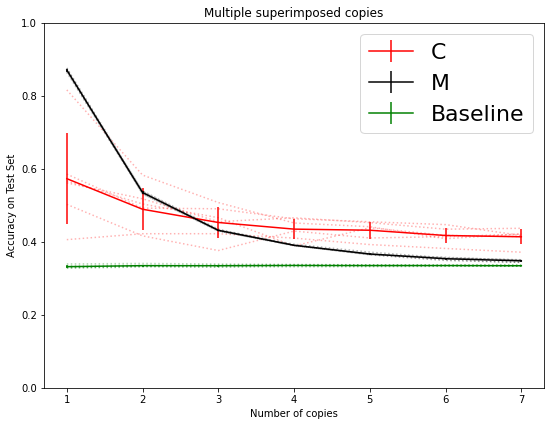

In [5]:
allAccuracies = np.load('allAccuracies.npy')
allAccuraciesM = np.load('allAccuraciesM.npy')
allAccuraciesBaseline = np.load('allAccuraciesBaseline.npy')


plt.figure(figsize=(1.4*6.4,1.4*4.8))
plt.ylim(0,1)
plt.title("Multiple superimposed copies")
plt.xticks(np.arange(1,maxNumWalkers+1))
plt.xlabel("Number of copies")
plt.ylabel("Accuracy on Test Set")

matplotlib.font_manager._rebuild()
plt.rcParams.update({'font.size': 22, 'font.family': 'FreeSans',
                    'mathtext.fontset': 'custom',
                    'mathtext.rm': 'FreeSans',
                    'mathtext.cal': 'FreeSans:oblique',
                    'mathtext.it': 'FreeSans:oblique',
                    'mathtext.bf': 'FreeSans:bold'})

for i in range(allAccuracies.shape[0]):
    plt.plot(np.arange(1,maxNumWalkers+1),allAccuracies[i],ls='dotted',color='red',alpha=0.3)
    plt.plot(np.arange(1,maxNumWalkers+1),allAccuraciesM[i],ls='dotted',color='black',alpha=0.3)
    plt.plot(np.arange(1,maxNumWalkers+1),allAccuraciesBaseline[i],ls='dotted',color='green',alpha=0.3)


plt.errorbar(np.arange(1,maxNumWalkers+1),np.mean(allAccuracies,axis=0),np.sqrt(np.var(allAccuracies,axis=0)),label="C",color='red')
plt.errorbar(np.arange(1,maxNumWalkers+1),np.mean(allAccuraciesM,axis=0),np.sqrt(np.var(allAccuraciesM,axis=0)),label="M",color='black')
plt.errorbar(np.arange(1,maxNumWalkers+1),np.mean(allAccuraciesBaseline,axis=0),np.sqrt(np.var(allAccuraciesBaseline,axis=0)),label="Baseline",color='green')


plt.legend()
plt.savefig('./accuracyVnumProcesses.png')
